In [ ]:
! git clone https://github.com/tzpranto/NIDS_NSYSS_23

Cloning into 'idsgan18'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 46 (delta 10), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (46/46), done.
Checking out files: 100% (34/34), done.


In [ ]:
cd NIDS_NSYSS_23/idsgan18/

/content/idsgan18


In [ ]:
cd ..

/content/idsgan18


In [ ]:
!ls -l

total 808916
-rw-r--r-- 1 root root 160082766 Apr 23 22:41 blackbox_train.csv
-rw-r--r-- 1 root root  85665467 Apr 23 22:41 discriminator_train_normal.csv
-rw-r--r-- 1 root root 100442630 Apr 23 22:41 GAN_train.csv
-rw-r--r-- 1 root root   6137305 Apr 23 22:41 generator_test_attack.csv
-rw-r--r-- 1 root root  30848053 Apr 23 22:41 generator_test_combined.csv
-rw-r--r-- 1 root root  24712515 Apr 23 22:41 generator_test_normal.csv
-rw-r--r-- 1 root root  14778930 Apr 23 22:41 generator_train.csv
-rw-r--r-- 1 root root   1814092 Apr 23 22:15 KDDTest-21.txt
-rw-r--r-- 1 root root  57270074 Apr 23 22:15 KDDTest+.csv
-rw-r--r-- 1 root root   3441513 Apr 23 22:15 KDDTest+.txt
-rw-r--r-- 1 root root   3822033 Apr 23 22:15 KDDTrain+_20Percent.txt
-rw-r--r-- 1 root root 320170229 Apr 23 22:15 KDDTrain+.csv
-rw-r--r-- 1 root root  19109424 Apr 23 22:15 KDDTrain+.txt


In [ ]:
!python data_generator.py

#Training RNN IDS

In [ ]:
import torch
from torch import nn


class Blackbox_IDS(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, 80, 1, batch_first=True)
        self.layer = nn.Sequential(
            nn.Dropout(0.1),
            nn.ReLU(True),
            nn.Linear(80, 40),
            nn.ReLU(True),
            nn.Linear(40, 20),
            nn.ReLU(True),
            nn.Linear(20, 5),
            nn.ReLU(True),
            nn.Linear(5, output_dim),
        )

    def forward(self, x):
        x = self.lstm(x)[0]
        x = torch.squeeze(x)
        x = self.layer(x)
        x = torch.nn.Sigmoid()(x)
        return x


In [ ]:
import pandas as pd
import torch
from sklearn.metrics import confusion_matrix
from preprocessing import preprocess3, create_batch1
#from model.model_class import Blackbox_IDS
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(12345)
torch.manual_seed(12345)

import random

random.seed(12345)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train = pd.read_csv('dataset/blackbox_train.csv')
test = pd.read_csv('dataset/KDDTest+.csv')

trainx, trainy, testx, testy = preprocess3(train, test)
#trainx, _, trainy, _ = train_test_split(trainx, trainy, test_size=0.1, random_state=12345)
print(trainx.shape)

input_dim = trainx.shape[1]
output_dim = 1
batch_size = 64
tr_N = len(trainx)
te_N = len(testx)
ids_model = Blackbox_IDS(input_dim, output_dim).to(device)
optimizer = torch.optim.Adam(ids_model.parameters(), lr=0.001)
loss_f = torch.nn.BCELoss()
max_epoch = 50
train_losses, test_losses = [], []


def train(x, y):
    ids_model.train()
    batch_x, batch_y = create_batch1(x, y, batch_size)
    run_loss = 0
    for x, y in zip(batch_x, batch_y):
        ids_model.zero_grad()
        x_t = torch.FloatTensor(x).to(device)
        x_t = torch.reshape(x_t, [batch_size,1,-1])
        y_t = torch.FloatTensor(y).to(device)
        y_t = torch.reshape(y_t, [batch_size])

        out = ids_model(x_t)
        out = torch.reshape(out, [batch_size])

        loss = loss_f(out, y_t)

        run_loss += loss.item()
        loss.backward()
        optimizer.step()
    return run_loss / tr_N


def test(x, y):
    ids_model.eval()
    batch_x, batch_y = create_batch1(x, y, batch_size)
    run_loss = 0

    with torch.no_grad():
        for x, y in zip(batch_x, batch_y):
            x_t = torch.FloatTensor(x).to(device)
            x_t = torch.reshape(x_t, [batch_size,1,-1])
            y_t = torch.FloatTensor(y).to(device)
            y_t = torch.reshape(y_t, [batch_size])

            out = ids_model(x_t)
            out = torch.reshape(out, [batch_size])

            loss = loss_f(out, y_t)

            run_loss += loss.item()
    return run_loss / te_N


def main():
    print("IDS start training")
    print("-" * 100)
    for epoch in range(max_epoch):
        train_loss = train(trainx, trainy)
        test_loss = test(testx, testy)

        x_t = torch.FloatTensor(testx).to(device)
        x_t = torch.reshape(x_t, [x_t.shape[0],1,-1])

        out = ids_model(x_t)
        out = torch.reshape(out, [len(testy)])
        out_np = out.cpu().detach().numpy()

        ids_pred_label = np.array(out_np > 0.5).astype(int)

        correct = np.sum(np.equal(ids_pred_label, testy))
        acc = correct / len(testy)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f"{epoch} : {train_loss} \t {test_loss} \t {acc}")

    print("IDS finished training")

    x_t = torch.FloatTensor(testx).to(device)
    x_t = torch.reshape(x_t, [x_t.shape[0],1,-1])
    out = ids_model(x_t)
    out = torch.reshape(out, [len(testy)])
    out_np = out.cpu().detach().numpy()

    ids_pred_label = np.array(out_np > 0.5).astype(int)

    conf_mat = confusion_matrix(testy, ids_pred_label)
    print(conf_mat)

    torch.save(ids_model.state_dict(), 'model/IDS.pth')
    plt.plot(train_losses, label="train")
    plt.plot(test_losses, label="test")
    plt.legend()
    plt.show()

In [ ]:
main()

In [ ]:
import torch
from torch.autograd import Variable
from torch import IntTensor
var = Variable(IntTensor([[1,0],[0,1]]))
print(list(var.size())[0])

In [ ]:
import os
class BlackBoxWrapper():
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.model = Blackbox_IDS(input_dim, output_dim).to(device)
        if os.path.exists('model/IDS.pth'):
            param = torch.load('model/IDS.pth')
            self.model.load_state_dict(param)
        else:
            print('BlackBox Model not saved yet')

    def __call__(self, x):
        x = torch.reshape(x, [x.shape[0],1,-1])
        x = self.model(x)
        return x

    def eval(self):
        self.model.eval()


#Training Fuzzyness IDS

In [ ]:
percent = 0.1
normal_index = 1

##Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import pprint
from pickle import dump

from sklearn.preprocessing import StandardScaler

pp = pprint.PrettyPrinter(indent=4)
debug = False

NSLKDD_ATTACK_DICT = {
    'DoS': ['apache2', 'back', 'land', 'neptune', 'mailbomb', 'pod', 'processtable', 'smurf', 'teardrop', 'udpstorm'],
    'Probe': ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan'],
    'Privilege': ['buffer_overflow', 'loadmodule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm','httptunnel'],
    'Access': ['ftp_write', 'guess_passwd', 'imap', 'multihop', 'named', 'phf', 'sendmail',
               'snmpgetattack', 'snmpguess', 'spy', 'warezclient', 'warezmaster', 'xlock', 'xsnoop','worm'],
    'Normal': ['normal']
}


NSLKDD_COL_NAMES = ["duration", "protocol_type", "service", "flag", "src_bytes",
                    "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
                    "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
                    "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
                    "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate",
                    "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
                    "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
                    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
                    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
                    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "class", "difficulty_level"]

binary = False

NSLKDD_ATTACK_MAP = dict()
for k, v in NSLKDD_ATTACK_DICT.items():
    for att in v:
        if not binary:
            NSLKDD_ATTACK_MAP[att] = k
        else:
            if k == 'Normal':
                NSLKDD_ATTACK_MAP[att] = k
            else:
                NSLKDD_ATTACK_MAP[att] = 'Attack'


FEATURE_CATEGORY = dict()

for i in range(9):
    FEATURE_CATEGORY.setdefault('intrinsic', []).append(NSLKDD_COL_NAMES[i])

for i in range(9, 22):
    FEATURE_CATEGORY.setdefault('content', []).append(NSLKDD_COL_NAMES[i])

for i in range(22, 31):
    FEATURE_CATEGORY.setdefault('time_based', []).append(NSLKDD_COL_NAMES[i])

for i in range(32, 41):
    FEATURE_CATEGORY.setdefault('host_based', []).append(NSLKDD_COL_NAMES[i])


FEATURE_CATEGORY_REV = dict()

for k,v in FEATURE_CATEGORY.items():
    for cat in list(v):
        FEATURE_CATEGORY_REV[cat] = k


FEATURE_TYPE = dict()

for i in [2, 3, 4]:
    FEATURE_TYPE.setdefault('categorical', []).append(NSLKDD_COL_NAMES[i - 1])

for i in [7, 12, 14, 20, 21, 22]:
    FEATURE_TYPE.setdefault('binary', []).append(NSLKDD_COL_NAMES[i - 1])

for i in [8, 9, 15, 43] + list(range(23, 42)):
    FEATURE_TYPE.setdefault('discrete', []).append(NSLKDD_COL_NAMES[i - 1])

for i in [1, 5, 6, 10, 11, 13, 16, 17, 18, 19]:
    FEATURE_TYPE.setdefault('continuous', []).append(NSLKDD_COL_NAMES[i - 1])


def create_batch1(x, y, batch_size):
    a = list(range(len(x)))
    np.random.shuffle(a)
    x = x[a]
    y = y[a]

    batch_x = [x[batch_size * i: (i + 1) * batch_size, :].tolist() for i in range(len(x) // batch_size)]
    batch_y = [y[batch_size * i: (i + 1) * batch_size].tolist() for i in range(len(x) // batch_size)]
    return batch_x, batch_y


def create_batch2(x, batch_size):
    a = list(range(len(x)))
    np.random.shuffle(a)
    x = x[a]
    batch_x = [x[batch_size * i: (i + 1) * batch_size, :] for i in range(len(x) // batch_size)]
    return np.array(batch_x).astype(float)


def preprocess4(train, functional_categories=None):
    if functional_categories is None:
        functional_categories = ['intrinsic', 'time_based']
    train["class"] = train["class"].map(lambda x: 1 if x != "Normal" else 0)

    raw_attack = np.array(train[train["class"] == 1])[:, :-1]
    normal = np.array(train[train["class"] == 0])[:, :-1]
    true_label = train["class"]

    del train["class"]

    train_columns = list(train.columns)

    modification_mask = np.ones((len(train.columns)))
    if functional_categories is None:
        functional_categories = ['intrinsic', 'time_based']

    for cat_ in functional_categories:
        cat_cols = list(FEATURE_CATEGORY[cat_])
        for cat_col in cat_cols:
            for idx in range(len(train_columns)):
                if str(train_columns[idx]).startswith(cat_col):
                    modification_mask[idx] = 0

    return train, raw_attack, normal, true_label, modification_mask


# all
def preprocess2(train, test, data_generation=False, attack_map=None):
    train.drop(['difficulty_level'], axis=1, inplace=True)
    test.drop(['difficulty_level'], axis=1, inplace=True)

    train.sample(frac=1)

    obj_cols = train.select_dtypes(include=['object']).copy().columns
    obj_cols = list(obj_cols)

    for col in obj_cols:

        if col != 'class':
            onehot_cols_train = pd.get_dummies(train[col], prefix=col, dtype='float64')
            onehot_cols_test = pd.get_dummies(test[col], prefix=col, dtype='float64')

            idx = 0
            for find_col_idx in range(len(list(train.columns))):
                if list(train.columns)[find_col_idx] == col:
                    idx = find_col_idx

            itr = 0
            for new_col in list(onehot_cols_train.columns):
                train.insert(idx + itr + 1, new_col, onehot_cols_train[new_col].values, True)

                if new_col not in list(onehot_cols_test.columns):
                    zero_col = np.zeros(test.values.shape[0])
                    test.insert(idx + itr + 1, new_col, zero_col, True)
                else:
                    test.insert(idx + itr + 1, new_col, onehot_cols_test[new_col].values, True)

                itr += 1

            del train[col]
            del test[col]

    if not data_generation:
        train["class"] = train["class"].map(lambda x: 1 if x != "Normal" else 0)
        test["class"] = test["class"].map(lambda x: 1 if x != "Normal" else 0)
    else:
        train["class"] = train["class"].map(attack_map)
        test["class"] = test["class"].map(attack_map)

    columns = train.columns
    train["num_outbound_cmds"] = train["num_outbound_cmds"].map(lambda x: 0)
    test["num_outbound_cmds"] = test["num_outbound_cmds"].map(lambda x: 0)

    if not data_generation:
        trainx, trainy = np.array(train[train.columns[train.columns != "class"]]), np.array(train["class"])
        testx, testy = np.array(test[train.columns[train.columns != "class"]]), np.array(test["class"])

        scaler = StandardScaler()
        scaler.fit(trainx)

        trainx = scaler.transform(trainx)
        testx = scaler.transform(testx)

        return trainx, trainy, testx, testy
    else:
        trainx, trainy = train[train.columns[train.columns != "class"]], train["class"]
        testx, testy = test[train.columns[train.columns != "class"]], test["class"]

        columns = trainx.columns
        scaler = StandardScaler()
        scaler.fit(trainx)

        trainx = scaler.transform(trainx)
        testx = scaler.transform(testx)

        train_processed = pd.DataFrame(trainx, columns=columns)
        train_processed["class"] = trainy

        test_processed = pd.DataFrame(testx, columns=columns)
        test_processed["class"] = testy

        return train_processed, test_processed


def preprocess3(train, test):
    train["class"] = train["class"].map(lambda x: 1 if x != "Normal" else 0)
    test["class"] = test["class"].map(lambda x: 1 if x != "Normal" else 0)

    train_np = train.values
    test_np = test.values

    trainx, trainy = train_np[:, :-1], train_np[:, -1]
    testx, testy = test_np[:, :-1], test_np[:, -1]

    testy = np.array(testy).astype(int)
    trainy = np.array(trainy).astype(int)

    return trainx, trainy, testx, testy



def preprocess5(train):
    #print(train["class"])
    #train["class"] = train["class"].map(NSLKDD_ATTACK_MAP)
    train["class"] = train["class"].astype('category')
    #print(train["class"].cat.categories)
    cat_dict_r = dict(enumerate(train["class"].cat.categories))
    cat_dict = dict()

    #print("Cat dict R")
    #print(cat_dict_r)
    for key, value in cat_dict_r.items():
        cat_dict[value] = key

    #print("Cat dict")
    #print(cat_dict)

    train = train.replace({"class": cat_dict})
    #print(train["class"])
    train["class"] = train["class"].astype('int64')

    train_np = train.values

    trainx, trainy = train_np[:, :-1], train_np[:, -1]
    #print(trainy)
    trainy = np.array(trainy).astype(int)

    return trainx, trainy

##Model

In [ ]:
from preprocessing import preprocess3
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from math import log
import sys
import numpy as np
import pandas as pd
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split


train = pd.read_csv('dataset/blackbox_train.csv')
test = pd.read_csv('dataset/KDDTest+.csv')

trainx, trainy = preprocess5(train)
testx, testy = preprocess5(test)
#print(np.unique(trainy, return_counts=True))
#print(np.unique(testy, return_counts=True))

trainx, valx, trainy, valy = train_test_split(trainx, trainy, test_size=percent, random_state=12345)

# valx = np.array([])
# valy = np.array([1,2,3,0,4])
#print(trainy[0], testy[0])

trainy = pd.DataFrame(to_categorical(trainy, 5)).values
valy = pd.DataFrame(to_categorical(valy, 5)).values
testy = pd.DataFrame(to_categorical(testy, 5)).values

#print(trainy[0], testy[0])
print(trainx.shape, trainy.shape)
print(valx.shape, valy.shape)
print(testx.shape, testy.shape)

(56686, 122) (56686, 5)
(6299, 122) (6299, 5)
(22544, 122) (22544, 5)


In [ ]:
def train_classifier(X, y):
    # create model
    model = Sequential()
    #model.add(Dense(40, input_dim=122, kernel_initializer='random_normal',bias_initializer='random_normal', activation='relu'))
    model.add(Dense(80, input_dim=122, activation='relu'))
    #model.add(Dense(60, activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(5, activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Fit the model
    model.fit(X, y, epochs=200, batch_size=256)

    return model


model = train_classifier(trainx, trainy)

score = model.evaluate(testx, testy)

print("Accuracy: ", score[1])

Epoch 1/200
222/222 [==============================] - 4s 2ms/step - loss: 0.5361 - accuracy: 0.8522
Epoch 2/200
222/222 [==============================] - 1s 2ms/step - loss: 0.0487 - accuracy: 0.9829
Epoch 3/200
222/222 [==============================] - 1s 2ms/step - loss: 0.0327 - accuracy: 0.9908
Epoch 4/200
222/222 [==============================] - 1s 2ms/step - loss: 0.0274 - accuracy: 0.9922
Epoch 5/200
222/222 [==============================] - 1s 2ms/step - loss: 0.0220 - accuracy: 0.9925
Epoch 6/200
222/222 [==============================] - 1s 2ms/step - loss: 0.0221 - accuracy: 0.9928
Epoch 7/200
222/222 [==============================] - 1s 2ms/step - loss: 0.0202 - accuracy: 0.9936
Epoch 8/200
222/222 [==============================] - 1s 2ms/step - loss: 0.0201 - accuracy: 0.9935
Epoch 9/200
222/222 [==============================] - 1s 2ms/step - loss: 0.0160 - accuracy: 0.9947
Epoch 10/200
222/222 [==============================] - 1s 2ms/step - loss: 0.0182 - accura

In [ ]:
membershipVectors = model.predict(valx) # Membership Matriloc
binarizedLabels = (membershipVectors == membershipVectors.max(axis=1, keepdims=1)).astype(float)

def F(V):
    def inner(mu):
        try:
            result = (mu * log(mu, 2)) + ((1 - mu) * log(1 - mu, 2))
        except:
            result = 0
        return result
    return - np.mean(list(map(inner, V)))

fuzziness = np.array(list(map(F, membershipVectors)))

print(fuzziness[0])

2.6458549620620446e-05


In [ ]:
#lowFuzzinessIndices = np.append(np.where( fuzziness >= 9/10), np.where( fuzziness <= 1/10 ) )
lowFuzzinessIndices = np.where( fuzziness <= 1/10 )
highFuzzinessIndices = np.logical_and(fuzziness >= 2/6, fuzziness <= 2/3)

# Fuzziness values >= 5/6
lowFuzzinessGroup = valx[ lowFuzzinessIndices ]
lowFuzzinessLabels = binarizedLabels[ lowFuzzinessIndices ]

# Fuzziness values 2/6 <= x <= 2/3
highFuzzinessGroup = valx[ highFuzzinessIndices ]
highFuzzinessLabels = binarizedLabels [ highFuzzinessIndices ]

# Append new samples to training set
#train_set_x = np.concatenate((train_set_x, lowFuzzinessGroup, highFuzzinessGroup), axis=0)

#train_set_y = np.concatenate((train_set_y, lowFuzzinessLabels, highFuzzinessLabels), axis=0)
trainx = np.concatenate((trainx, lowFuzzinessGroup), axis=0)

trainy = np.concatenate((trainy, lowFuzzinessLabels), axis=0)

In [ ]:
print(trainx.shape)
print(trainy.shape)
model = train_classifier(trainx, trainy)
score = model.evaluate(testx, testy)

print("Accuracy: ", score[1])

(62927, 122)
(62927, 5)
Epoch 1/200
246/246 [==============================] - 1s 2ms/step - loss: 0.4645 - accuracy: 0.8694
Epoch 2/200
246/246 [==============================] - 1s 2ms/step - loss: 0.0489 - accuracy: 0.9825
Epoch 3/200
246/246 [==============================] - 1s 2ms/step - loss: 0.0315 - accuracy: 0.9917
Epoch 4/200
246/246 [==============================] - 1s 2ms/step - loss: 0.0243 - accuracy: 0.9925
Epoch 5/200
246/246 [==============================] - 1s 2ms/step - loss: 0.0220 - accuracy: 0.9935
Epoch 6/200
246/246 [==============================] - 1s 2ms/step - loss: 0.0212 - accuracy: 0.9935
Epoch 7/200
246/246 [==============================] - 1s 2ms/step - loss: 0.0173 - accuracy: 0.9949
Epoch 8/200
246/246 [==============================] - 1s 2ms/step - loss: 0.0185 - accuracy: 0.9948
Epoch 9/200
246/246 [==============================] - 1s 2ms/step - loss: 0.0177 - accuracy: 0.9944
Epoch 10/200
246/246 [==============================] - 1s 2ms/step

##BlackBox IDS

In [ ]:
def getPred(x):
    y = model.predict(x)
    y_c = y.argmax(axis=-1)
    y_bin = []
    for val in y_c:
        if val == normal_index:
            y_bin.append(0)
        else:
            y_bin.append(1)
    return np.array(y_bin)

In [ ]:
import os
class BlackBoxWrapper():
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim

    def __call__(self, x):
        x = x.cpu().detach().numpy()
        x = getPred(x)
        x = torch.FloatTensor(x).to(device)
        return x

    def eval(self):
        x = 1

#Training Our IDS

In [ ]:
! git clone -b master https://github.com/smmr1405020/NIDS-Project

Cloning into 'NIDS-Project'...
remote: Enumerating objects: 865, done.
remote: Counting objects: 100% (610/610), done.
remote: Compressing objects: 100% (466/466), done.
remote: Total 865 (delta 184), reused 567 (delta 143), pack-reused 255
Receiving objects: 100% (865/865), 163.33 MiB | 33.90 MiB/s, done.
Resolving deltas: 100% (314/314), done.


In [ ]:
cd NIDS-Project/

/content/idsgan18/NIDS-Project


In [ ]:
!mkdir Output
!ls

data_generator.py  Dataset_NSLKDD_2  models  Output  training_file.py


##Data Loader

In [ ]:
import pandas as pd
import numpy as np
import pprint
from pickle import dump

from sklearn.preprocessing import StandardScaler

pp = pprint.PrettyPrinter(indent=4)
debug = False

NSLKDD_ATTACK_DICT = {
    'DoS': ['apache2', 'back', 'land', 'neptune', 'mailbomb', 'pod', 'processtable', 'smurf', 'teardrop', 'udpstorm'],
    'Probe': ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan'],
    'Privilege': ['buffer_overflow', 'loadmodule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm','httptunnel'],
    'Access': ['ftp_write', 'guess_passwd', 'imap', 'multihop', 'named', 'phf', 'sendmail',
               'snmpgetattack', 'snmpguess', 'spy', 'warezclient', 'warezmaster', 'xlock', 'xsnoop','worm'],
    'Normal': ['normal']
}


NSLKDD_COL_NAMES = ["duration", "protocol_type", "service", "flag", "src_bytes",
                    "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
                    "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
                    "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
                    "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate",
                    "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
                    "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
                    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
                    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
                    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "class", "difficulty_level"]

binary = False

NSLKDD_ATTACK_MAP = dict()
for k, v in NSLKDD_ATTACK_DICT.items():
    for att in v:
        if not binary:
            NSLKDD_ATTACK_MAP[att] = k
        else:
            if k == 'Normal':
                NSLKDD_ATTACK_MAP[att] = k
            else:
                NSLKDD_ATTACK_MAP[att] = 'Attack'


FEATURE_CATEGORY = dict()

for i in range(9):
    FEATURE_CATEGORY.setdefault('intrinsic', []).append(NSLKDD_COL_NAMES[i])

for i in range(9, 22):
    FEATURE_CATEGORY.setdefault('content', []).append(NSLKDD_COL_NAMES[i])

for i in range(22, 31):
    FEATURE_CATEGORY.setdefault('time_based', []).append(NSLKDD_COL_NAMES[i])

for i in range(32, 41):
    FEATURE_CATEGORY.setdefault('host_based', []).append(NSLKDD_COL_NAMES[i])


FEATURE_CATEGORY_REV = dict()

for k,v in FEATURE_CATEGORY.items():
    for cat in list(v):
        FEATURE_CATEGORY_REV[cat] = k


FEATURE_TYPE = dict()

for i in [2, 3, 4]:
    FEATURE_TYPE.setdefault('categorical', []).append(NSLKDD_COL_NAMES[i - 1])

for i in [7, 12, 14, 20, 21, 22]:
    FEATURE_TYPE.setdefault('binary', []).append(NSLKDD_COL_NAMES[i - 1])

for i in [8, 9, 15, 43] + list(range(23, 42)):
    FEATURE_TYPE.setdefault('discrete', []).append(NSLKDD_COL_NAMES[i - 1])

for i in [1, 5, 6, 10, 11, 13, 16, 17, 18, 19]:
    FEATURE_TYPE.setdefault('continuous', []).append(NSLKDD_COL_NAMES[i - 1])


def create_batch1(x, y, batch_size):
    a = list(range(len(x)))
    np.random.shuffle(a)
    x = x[a]
    y = y[a]

    batch_x = [x[batch_size * i: (i + 1) * batch_size, :].tolist() for i in range(len(x) // batch_size)]
    batch_y = [y[batch_size * i: (i + 1) * batch_size].tolist() for i in range(len(x) // batch_size)]
    return batch_x, batch_y


def create_batch2(x, batch_size):
    a = list(range(len(x)))
    np.random.shuffle(a)
    x = x[a]
    batch_x = [x[batch_size * i: (i + 1) * batch_size, :] for i in range(len(x) // batch_size)]
    return np.array(batch_x).astype(float)


def preprocess4(train, functional_categories=None):
    if functional_categories is None:
        functional_categories = ['intrinsic', 'time_based']
    train["class"] = train["class"].map(lambda x: 1 if x != "Normal" else 0)

    raw_attack = np.array(train[train["class"] == 1])[:, :-1]
    normal = np.array(train[train["class"] == 0])[:, :-1]
    true_label = train["class"]

    del train["class"]

    train_columns = list(train.columns)

    modification_mask = np.ones((len(train.columns)))
    if functional_categories is None:
        functional_categories = ['intrinsic', 'time_based']

    for cat_ in functional_categories:
        cat_cols = list(FEATURE_CATEGORY[cat_])
        for cat_col in cat_cols:
            for idx in range(len(train_columns)):
                if str(train_columns[idx]).startswith(cat_col):
                    modification_mask[idx] = 0

    return train, raw_attack, normal, true_label, modification_mask


# all
def preprocess2(train, test, data_generation=False, attack_map=None):
    train.drop(['difficulty_level'], axis=1, inplace=True)
    test.drop(['difficulty_level'], axis=1, inplace=True)

    train.sample(frac=1)

    obj_cols = train.select_dtypes(include=['object']).copy().columns
    obj_cols = list(obj_cols)

    for col in obj_cols:

        if col != 'class':
            onehot_cols_train = pd.get_dummies(train[col], prefix=col, dtype='float64')
            onehot_cols_test = pd.get_dummies(test[col], prefix=col, dtype='float64')

            idx = 0
            for find_col_idx in range(len(list(train.columns))):
                if list(train.columns)[find_col_idx] == col:
                    idx = find_col_idx

            itr = 0
            for new_col in list(onehot_cols_train.columns):
                train.insert(idx + itr + 1, new_col, onehot_cols_train[new_col].values, True)

                if new_col not in list(onehot_cols_test.columns):
                    zero_col = np.zeros(test.values.shape[0])
                    test.insert(idx + itr + 1, new_col, zero_col, True)
                else:
                    test.insert(idx + itr + 1, new_col, onehot_cols_test[new_col].values, True)

                itr += 1

            del train[col]
            del test[col]

    if not data_generation:
        train["class"] = train["class"].map(lambda x: 1 if x != "Normal" else 0)
        test["class"] = test["class"].map(lambda x: 1 if x != "Normal" else 0)
    else:
        train["class"] = train["class"].map(attack_map)
        test["class"] = test["class"].map(attack_map)

    columns = train.columns
    train["num_outbound_cmds"] = train["num_outbound_cmds"].map(lambda x: 0)
    test["num_outbound_cmds"] = test["num_outbound_cmds"].map(lambda x: 0)

    if not data_generation:
        trainx, trainy = np.array(train[train.columns[train.columns != "class"]]), np.array(train["class"])
        testx, testy = np.array(test[train.columns[train.columns != "class"]]), np.array(test["class"])

        scaler = StandardScaler()
        scaler.fit(trainx)

        trainx = scaler.transform(trainx)
        testx = scaler.transform(testx)

        return trainx, trainy, testx, testy
    else:
        trainx, trainy = train[train.columns[train.columns != "class"]], train["class"]
        testx, testy = test[train.columns[train.columns != "class"]], test["class"]

        columns = trainx.columns
        scaler = StandardScaler()
        scaler.fit(trainx)

        trainx = scaler.transform(trainx)
        testx = scaler.transform(testx)

        train_processed = pd.DataFrame(trainx, columns=columns)
        train_processed["class"] = trainy

        test_processed = pd.DataFrame(testx, columns=columns)
        test_processed["class"] = testy

        return train_processed, test_processed


def preprocess3(train, test):
    train["class"] = train["class"].map(lambda x: 1 if x != "Normal" else 0)
    test["class"] = test["class"].map(lambda x: 1 if x != "Normal" else 0)

    train_np = train.values
    test_np = test.values

    trainx, trainy = train_np[:, :-1], train_np[:, -1]
    testx, testy = test_np[:, :-1], test_np[:, -1]

    testy = np.array(testy).astype(int)
    trainy = np.array(trainy).astype(int)

    return trainx, trainy, testx, testy



def preprocess5(train):
    #print(train["class"])
    #train["class"] = train["class"].map(NSLKDD_ATTACK_MAP)
    train["class"] = train["class"].astype('category')
    #print(train["class"].cat.categories)
    cat_dict_r = dict(enumerate(train["class"].cat.categories))
    cat_dict = dict()

    #print("Cat dict R")
    #print(cat_dict_r)
    for key, value in cat_dict_r.items():
        cat_dict[value] = key

    #print("Cat dict")
    #print(cat_dict)

    train = train.replace({"class": cat_dict})
    #print(train["class"])
    train["class"] = train["class"].astype('int64')

    train_np = train.values

    trainx, trainy = train_np[:, :-1], train_np[:, -1]
    #print(trainy)
    trainy = np.array(trainy).astype(int)

    return trainx, trainy


###Main Loader

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset

np.random.seed(12345)
torch.manual_seed(12345)
import random

random.seed(12345)

NSLKDD_ATTACK_DICT = {
    'DoS': ['apache2', 'back', 'land', 'neptune', 'mailbomb', 'pod', 'processtable', 'smurf', 'teardrop', 'udpstorm'],
    'Probe': ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan'],
    'Privilege': ['buffer_overflow', 'loadmodule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm','httptunnel'],
    'Access': ['ftp_write', 'guess_passwd', 'imap', 'multihop', 'named', 'phf', 'sendmail',
               'snmpgetattack', 'snmpguess', 'spy', 'warezclient', 'warezmaster', 'xlock', 'xsnoop','worm'],
    'Normal': ['normal']
}

nslkdd_col_names = ["duration", "protocol_type", "service", "flag", "src_bytes",
                    "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
                    "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
                    "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
                    "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate",
                    "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
                    "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
                    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
                    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
                    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label", "difficulty_level"]

binary = False

NSLKDD_ATTACK_MAP = dict()
for k, v in NSLKDD_ATTACK_DICT.items():
    for att in v:
        if not binary:
            NSLKDD_ATTACK_MAP[att] = k
        else:
            if k == 'Normal':
                NSLKDD_ATTACK_MAP[att] = k
            else:
                NSLKDD_ATTACK_MAP[att] = 'Attack'

cat_dict = dict()

max_weight = 100


def load_nslkdd(train_data=True, test_data_neg=False):
    nRowsRead = None  # specify 'None' if want to read whole file

    df1 = pd.read_csv('Dataset_NSLKDD_2/KDDTrain+_20Percent.txt', delimiter=',', header=None, names=nslkdd_col_names,
                      nrows=nRowsRead)
    df1.dataframeName = 'KDDTrain+_20Percent'

    df2 = pd.read_csv('Dataset_NSLKDD_2/KDDTest+.txt', delimiter=',', header=None, names=nslkdd_col_names)
    df2.dataframeName = 'KDDTest+.txt'

    df3 = pd.read_csv('Dataset_NSLKDD_2/KDDTest-21.txt', delimiter=',', header=None, names=nslkdd_col_names)
    df3.dataframeName = 'KDDTest-21.txt'

    df1.drop(['difficulty_level'], axis=1, inplace=True)
    df2.drop(['difficulty_level'], axis=1, inplace=True)
    df3.drop(['difficulty_level'], axis=1, inplace=True)

    df1.sample(frac=1)

    obj_cols = df1.select_dtypes(include=['object']).copy().columns
    obj_cols = list(obj_cols)

    for col in obj_cols:

        if col != 'label':
            onehot_cols_train = pd.get_dummies(df1[col], prefix=col, dtype='float64')
            onehot_cols_test = pd.get_dummies(df2[col], prefix=col, dtype='float64')
            onehot_cols_test2 = pd.get_dummies(df3[col], prefix=col, dtype='float64')

            idx = 0
            for find_col_idx in range(len(list(df1.columns))):
                if list(df1.columns)[find_col_idx] == col:
                    idx = find_col_idx

            itr = 0
            for new_col in list(onehot_cols_train.columns):
                df1.insert(idx + itr + 1, new_col, onehot_cols_train[new_col].values, True)

                if new_col not in list(onehot_cols_test.columns):
                    zero_col = np.zeros(df2.values.shape[0])
                    df2.insert(idx + itr + 1, new_col, zero_col, True)
                else:
                    df2.insert(idx + itr + 1, new_col, onehot_cols_test[new_col].values, True)

                if new_col not in list(onehot_cols_test2.columns):
                    zero_col = np.zeros(df3.values.shape[0])
                    df3.insert(idx + itr + 1, new_col, zero_col, True)
                else:
                    df3.insert(idx + itr + 1, new_col, onehot_cols_test2[new_col].values, True)

                itr += 1

            del df1[col]
            del df2[col]
            del df3[col]

        else:

            df1[col] = df1[col].map(NSLKDD_ATTACK_MAP)
            df2[col] = df2[col].map(NSLKDD_ATTACK_MAP)
            df3[col] = df3[col].map(NSLKDD_ATTACK_MAP)

            df1[col] = df1[col].astype('category')

            cat_dict_r = dict(enumerate(df1[col].cat.categories))

            for key, value in cat_dict_r.items():
                cat_dict[value] = key

            df1 = df1.replace({col: cat_dict})
            df1[col] = df1[col].astype('int64')

            df2[col] = df2[col].astype('category')
            df2 = df2.replace({col: cat_dict})

            for i in range(len(df2[col])):
                if type(df2[col][i]) is str:
                    df2.at[i, col] = len(cat_dict) + 1

            df2[col] = df2[col].astype('int64')

            df3[col] = df3[col].astype('category')
            df3 = df3.replace({col: cat_dict})

            for i in range(len(df3[col])):
                if type(df3[col][i]) is str:
                    df3.at[i, col] = len(cat_dict) + 1

            df3[col] = df3[col].astype('int64')

    # df1 = df1[df1.labels != cat_dict['Normal']]

    normal_label = cat_dict['Normal']

    train_X = df1.values[:, :-1]
    train_Y = df1.values[:, -1]

    test_X = df2.values[:, :-1]
    test_Y = df2.values[:, -1]

    test_Y = np.array(test_Y).astype(np.int64)

    test_X2 = df3.values[:, :-1]
    test_Y2 = df3.values[:, -1]

    test_Y2 = np.array(test_Y2).astype(np.int64)

    scaler = StandardScaler()
    scaler.fit(train_X)

    train_X = scaler.transform(train_X)
    test_X = scaler.transform(test_X)
    test_X2 = scaler.transform(test_X2)

    if train_data:
        return train_X, train_Y
    elif not test_data_neg:
        return test_X, test_Y
    else:
        return test_X2, test_Y2


def load_unsw_nb15(train_data=True):
    nRowsRead = None  # specify 'None' if want to read whole file

    df1 = pd.read_csv('Dataset_UNSW_NB15/UNSW_NB15_train.csv', delimiter=',',
                      nrows=nRowsRead)
    df1.dataframeName = 'UNSW_NB15_train.csv'

    df2 = pd.read_csv('Dataset_UNSW_NB15/UNSW_NB15_test.csv', delimiter=',')
    df2.dataframeName = 'UNSW_NB15_test.csv'

    # print(df1['attack_cat'].unique())

    df1.sample(frac=1)
    df1.drop(['id'], axis=1, inplace=True)
    df2.drop(['id'], axis=1, inplace=True)

    if not binary:
        df1.drop(['label'], axis=1, inplace=True)
        df2.drop(['label'], axis=1, inplace=True)
        lbl = 'attack_cat'
    else:
        df1.drop(['attack_map'], axis=1, inplace=True)
        df2.drop(['attack_map'], axis=1, inplace=True)
        lbl = 'label'

    obj_cols = df1.select_dtypes(include=['object']).copy().columns
    obj_cols = list(obj_cols)

    for col in obj_cols:

        if col != lbl:
            onehot_cols_train = pd.get_dummies(df1[col], prefix=col, dtype='float64')
            onehot_cols_test = pd.get_dummies(df2[col], prefix=col, dtype='float64')

            idx = 0
            for find_col_idx in range(len(list(df1.columns))):
                if list(df1.columns)[find_col_idx] == col:
                    idx = find_col_idx

            itr = 0
            for new_col in list(onehot_cols_train.columns):
                df1.insert(idx + itr + 1, new_col, onehot_cols_train[new_col].values, True)

                if new_col not in list(onehot_cols_test.columns):
                    zero_col = np.zeros(df2.values.shape[0])
                    df2.insert(idx + itr + 1, new_col, zero_col, True)
                else:
                    df2.insert(idx + itr + 1, new_col, onehot_cols_test[new_col].values, True)

                itr += 1

            del df1[col]
            del df2[col]

        else:

            df1[col] = df1[col].astype('category')

            cat_dict_r = dict(enumerate(df1[col].cat.categories))

            for key, value in cat_dict_r.items():
                cat_dict[value] = key

            df1 = df1.replace({col: cat_dict})
            df1[col] = df1[col].astype('int64')

            df2[col] = df2[col].astype('category')
            df2 = df2.replace({col: cat_dict})

            for i in range(len(df2[col])):
                if type(df2[col][i]) is str:
                    df2.at[i, col] = len(cat_dict) + 1

            df2[col] = df2[col].astype('int64')

    train_X = df1.values[:, :-1]
    train_Y = df1.values[:, -1]

    test_X = df2.values[:, :-1]
    test_Y = df2.values[:, -1]

    test_Y = np.array(test_Y).astype(np.int64)

    scaler = StandardScaler()
    scaler.fit(train_X)

    train_X = scaler.transform(train_X)
    test_X = scaler.transform(test_X)

    # print(train_X.shape)
    # print(train_Y.shape)
    # print(test_X.shape)
    # print(test_Y.shape)

    if train_data:
        return train_X, train_Y
    else:
        return test_X, test_Y

load_nslkdd()

def get_training_data(label_ratio):
    train = pd.read_csv('../dataset/blackbox_train.csv')
    print(train.shape)
    train_X, train_Y = preprocess5(train)

    trYunique, trYcounts = np.unique(train_Y, return_counts=True)
    got_once = np.zeros(len(trYunique))

    global max_weight
    max_weight = np.max(trYcounts) / np.min(trYcounts)

    for i in range(len(train_Y)):
        p = np.random.rand()
        if p > label_ratio and got_once[int(train_Y[i])] == 1:
            train_Y[i] = -1
        else:
            got_once[int(train_Y[i])] = 1

    labeled_data_X = []
    labeled_data_Y = []
    unlabeled_data_X = []
    unlabeled_data_Y = []
    for i in range(len(train_Y)):
        if train_Y[i] != -1:
            labeled_data_X.append(list(train_X[i]))
            labeled_data_Y.append(train_Y[i])
        else:
            unlabeled_data_X.append(list(train_X[i]))
            unlabeled_data_Y.append(train_Y[i])

    labeled_data = np.array(labeled_data_X), np.array(labeled_data_Y)
    unlabeled_data = np.array(unlabeled_data_X), np.array(unlabeled_data_Y)

    if len(unlabeled_data[1]) != 0 and len(labeled_data[1]) != 0:
        total_data_X = np.append(labeled_data[0], unlabeled_data[0], axis=0)
        total_data_Y = np.append(labeled_data[1], unlabeled_data[1], axis=0)
    elif len(unlabeled_data[1]) == 0:
        total_data_X = labeled_data[0]
        total_data_Y = labeled_data[1]
    else:
        total_data_X = unlabeled_data[0]
        total_data_Y = unlabeled_data[1]

    total_data = total_data_X, total_data_Y

    total_dataset = dataset_train(total_data)
    labeled_dataset = dataset_train(labeled_data)
    unlabeled_dataset = dataset_train(unlabeled_data)

    return total_dataset, labeled_dataset, unlabeled_dataset


class dataset_train(Dataset):

    def __init__(self, data):
        self.x = data[0]
        self.y = data[1]

    def set_x(self, new_x):
        self.x = new_x

    def get_x(self):
        return self.x

    def set_y(self, new_y):
        self.y = new_y

    def get_y(self):
        return self.y

    def get_feature_shape(self):
        return self.x.shape[1]

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        if debug:
            print("Inside get item....")
            print(self.y[idx])
            print(np.array(self.x).shape , np.array(self.y).shape)
            print(torch.from_numpy(np.array(self.x[idx])).shape)
            print(torch.LongTensor(np.array(self.y))[idx])
            print(torch.LongTensor([idx]).squeeze())
        return torch.from_numpy(np.array(self.x[idx])), torch.LongTensor(np.array(self.y))[idx], \
               torch.LongTensor([idx]).squeeze()

    def get_weight(self):

        trYunique, trYcounts = np.unique(self.y, return_counts=True)
        max_count = 0
        for i in range(len(trYcounts)):
            if trYunique[i] != -1 and trYcounts[i] > max_count:
                max_count = trYcounts[i]

        labels = list(cat_dict.values())
        no_labels = len(labels)
        weights = np.ones(no_labels)
        for i in range(len(trYunique)):
            if trYunique[i] >= 0 and trYcounts[i] > 0:
                weights[int(trYunique[i])] = min(max_weight, max_count / trYcounts[i])

        return weights

    def add_sample(self, sample_X, sample_Y):
        self.x = np.concatenate([self.x, np.expand_dims(sample_X, axis=0)], axis=0)
        self.y = np.append(self.y, sample_Y)


class dataset_test(Dataset):

    def __init__(self, test_neg=False):
        test = pd.read_csv('../dataset/KDDTest+.csv')
        self.x, self.y = preprocess5(test)
        self.feature_size = self.x.shape[1]

    def __len__(self):
        return self.x.shape[0]

    def set_x(self, new_x):
        self.x = new_x

    def get_x(self):
        return self.x

    def get_y(self):
        return self.y

    def __getitem__(self, idx):
        return torch.from_numpy(np.array(self.x[idx])), torch.LongTensor(np.array(self.y))[idx], \
               torch.LongTensor([idx]).squeeze()

##Train

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.nn import Linear
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
import os, glob
import pickle
from google.colab import files

np.random.seed(12345)
torch.manual_seed(12345)
import random

# 0.01: trainstop 0.005, cluster /25, min_imp_dec: 0.01, (80,100,150) , 5:15PM 26/11/20


random.seed(12345)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
total_dataset, labeled_dataset, unlabeled_dataset = get_training_data(label_ratio=0.1)
test_dataset = dataset_test()
print(total_dataset.get_x().shape)

ae_epoch = 80
pretrain_epoch = 200
train_epoch = 150

num_data = total_dataset.get_x()
labels = total_dataset.get_y()

if debug:
    print("Inside train code: ",labels)

total_original_label_counts = dict()
distinct_labels, distinct_label_counts = np.unique(labels, return_counts=True)
for i in range(len(distinct_labels)):
    if distinct_labels[i] != -1:
        total_original_label_counts[distinct_labels[i]] = distinct_label_counts[i]


# print(total_original_label_counts)


def tree_work(load_cluster_from_file=False):
    if load_cluster_from_file:
        clustering = pickle.load(file=open('models/clustering.pkl', 'rb'))
    else:
        clustering = KMeans(n_clusters=int(total_dataset.__len__() / 175), random_state=0)
        print("Clustering Started.")
        clustering.fit(num_data)
        print("Clustering ended.")

    cluster_assignment = clustering.labels_
    all_clusters = dict()
    for j in range(len(cluster_assignment)):
        all_clusters.setdefault(cluster_assignment[j], []).append(num_data[j])

    cluster_to_label_dict = dict()
    for j in range(len(cluster_assignment)):
        if labels[j] != -1:
            cluster_to_label_dict.setdefault(cluster_assignment[j], []).append(labels[j])

    #print("Clusters:")
    label_to_cluster_dict = dict()
    for k, v in cluster_to_label_dict.items():
        cl_labels, cl_label_counts = np.unique(np.array(v), return_counts=True)  # labeled member count in each cluster
        # print(k)
        # print(cl_labels)
        # print(cl_label_counts)
        # print("\n")
        total_labeled_counts = np.sum(cl_label_counts)

        max_label = np.argmax(cl_label_counts)

        '''
        If a cluster contains more than 10% of all samples of a label present in the training dataset, it is considered
        important for this label.
        If the majority label is not the normal label and there are no other labels for which this cluster is important,
        having more than 50% of the labeled members would be enough for soft labeling
        If the majority label is the normal label, then all labeled members must be normal for soft labeling.
        In any other case, we do not soft label.
        '''

        imp_for_label = []
        for label, total_label_count in total_original_label_counts.items():
            for j in range(len(cl_labels)):
                if cl_labels[j] == label and cl_label_counts[j] > 0.1 * total_label_count:
                    imp_for_label.append(label)

        if (cl_label_counts[max_label] / total_labeled_counts) > 0.5:
            selected_label = cl_labels[max_label]
            if len(imp_for_label) == 1:
                if imp_for_label[0] == selected_label:
                    if selected_label != int(cat_dict['Normal']):
                        label = selected_label
                        size = len(v)
                        label_to_cluster_dict.setdefault(label, []).append([k, size])
                    else:
                        if len(cl_labels) == 1:
                            label = selected_label
                            size = len(v)
                            label_to_cluster_dict.setdefault(label, []).append([k, size])
            elif len(imp_for_label) == 0:
                if selected_label != int(cat_dict['Normal']):
                    label = selected_label
                    size = len(v)
                    label_to_cluster_dict.setdefault(label, []).append([k, size])
                else:
                    if len(cl_labels) == 1:
                        label = selected_label
                        size = len(v)
                        label_to_cluster_dict.setdefault(label, []).append([k, size])

    '''
    clusters that belong to a particular label, after soft labeling.
    '''
    soft_label_mapping = dict()
    for k, v in label_to_cluster_dict.items():
        for cluster_index in v:
            soft_label_mapping[cluster_index[0]] = k

    '''
    soft labeling particular unlabeled samples.
    Also add this to labeled dataset.
    '''

    for j in range(len(labels)):
        if labels[j] == -1 and (int(cluster_assignment[j]) in soft_label_mapping.keys()):
            labels[j] = soft_label_mapping[cluster_assignment[j]]
            labeled_dataset.add_sample(num_data[j], labels[j])


    '''
    checking total labeled and soft labeled members.
    '''

    total_soft_label_counts = dict()
    distinct_slabels, distinct_slabel_counts = np.unique(labels, return_counts=True)
    for j in range(len(distinct_slabels)):
        if distinct_slabels[j] != -1:
            total_soft_label_counts[distinct_slabels[j]] = distinct_slabel_counts[j]

    print(total_soft_label_counts)

    cluster_to_labels_dict = dict()
    for k, v in cluster_to_label_dict.items():
        cl_labels = np.unique(np.array(v))
        cl_labels = sorted(list(cl_labels))
        if cl_labels[0] == -1:
            cl_labels = cl_labels[1:]
        cluster_to_labels_dict[k] = cl_labels

    total_dataset.set_y(labels)

    dt_X = labeled_dataset.get_x()
    dt_Y = labeled_dataset.get_y()

    print("labeled members dimensions:")
    print(dt_X.shape)
    print(dt_Y.shape)

    clf = DecisionTreeClassifier(random_state=0, max_leaf_nodes=7)
    clf.fit(dt_X, dt_Y)

    print("No. of leaves of decision tree:")
    print(clf.get_n_leaves())

    '''
    saving decision tree, cluster membership info (this is just to skip the clustering step for our faster use) and soft
    labeling info.
    '''

    file = open('models/tree.pkl', 'wb')
    pickle.dump(clf, file)
    file.close()

    for k in list(all_clusters.keys()):
        if int(k) not in soft_label_mapping.keys():
            soft_label_mapping[int(k)] = int(cat_dict['Normal'])

    file = open('models/soft_label_mapping.pkl', 'wb')
    pickle.dump(soft_label_mapping, file)
    file.close()

    if not load_cluster_from_file:
        file = open('models/clustering.pkl', 'wb')
        pickle.dump(clustering, file)
        file.close()

    leaf_dataset_X = dict()
    leaf_dataset_Y = dict()

    '''
    finding out corresponding leaf for each training sample.
    '''

    for j in range(len(num_data)):
        leaf = clf.apply([num_data[j]])[0]
        if labels[j] != -1:
            leaf_dataset_X.setdefault(leaf, []).append(num_data[j])
            leaf_dataset_Y.setdefault(leaf, []).append(labels[j])

    for k, v in leaf_dataset_X.items():
        leaf_dataset_X[k] = np.array(leaf_dataset_X[k])
        leaf_dataset_Y[k] = np.array(leaf_dataset_Y[k])

    return leaf_dataset_X, leaf_dataset_Y

'''
The dictionary of X-Y training dataset for each individual leaf.
'''
leaf_dataset_X, leaf_dataset_Y = tree_work(load_cluster_from_file=False)

'''
undercomplete autoencoder for embedding.
'''

class AE(nn.Module):

    def __init__(self, n_input, n_z):
        super(AE, self).__init__()
        # encoder
        self.enc_1 = Linear(n_input, 80)
        self.enc_2 = Linear(80, 50)
        self.z_layer = Linear(50, n_z)

        # decoder
        self.dec_1 = Linear(n_z, 50)
        self.dec_2 = Linear(50, 80)
        self.x_bar_layer = Linear(80, n_input)

    def forward(self, x):
        # encoder
        enc_h1 = F.relu(self.enc_1(x))
        enc_h2 = F.relu(self.enc_2(enc_h1))
        z = self.z_layer(enc_h2)

        # decoder
        dec_h1 = F.relu(self.dec_1(z))
        dec_h2 = F.relu(self.dec_2(dec_h1))
        x_bar = self.x_bar_layer(dec_h2)

        return x_bar, z


def train_ae(epochs, load_from_file=False, save_path='models/train_ae'):
    '''
    train autoencoder
    '''

    model = AE(total_dataset.get_feature_shape(), 32)
    model.to(device)

    ae_train_ds = total_dataset
    training_data_length = int(0.7 * ae_train_ds.__len__())
    validation_data_length = ae_train_ds.__len__() - training_data_length
    training_data, validation_data = torch.utils.data.random_split(ae_train_ds,
                                                                   [training_data_length, validation_data_length])

    # print(total_dataset.__len__())
    # print(training_data.__len__())
    # print(validation_data.__len__())

    train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
    validation_loader = DataLoader(validation_data, batch_size=32, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    min_val_loss = 1000000

    for epoch in range(epochs):
        training_loss = 0.
        validation_loss = 0.
        train_batch_num = 0
        val_batch_num = 0

        model.train()
        for batch_idx, (x, _, idx) in enumerate(train_loader):
            x = x.float()
            x = x.to(device)

            train_batch_num = batch_idx

            optimizer.zero_grad()
            x_bar, z = model(x)
            loss = F.mse_loss(x_bar, x)
            training_loss += loss.item()

            loss.backward()
            optimizer.step()

        training_loss /= (train_batch_num + 1)

        model.eval()

        for batch_idx, (x, _, idx) in enumerate(validation_loader):
            x = x.float()
            x = x.to(device)

            val_batch_num = batch_idx

            x_bar, z = model(x)
            loss = F.mse_loss(x_bar, x)
            validation_loss += loss.item()

        validation_loss /= (val_batch_num + 1)

        if epoch % 1 == 0:
            print(
                "epoch {} , Training loss={:.4f}, Validation loss={:.4f}".format(epoch, training_loss, validation_loss))

        if epoch == 0 or min_val_loss > validation_loss:
            min_val_loss = validation_loss
            torch.save(model.state_dict(), save_path)

    print("model saved to {}.".format(save_path))
    return model


class leaf_dnn(nn.Module):

    def __init__(self, n_input, n_output):
        super(leaf_dnn, self).__init__()
        self.fc1 = nn.Linear(n_input, 8)
        self.fc2 = nn.Linear(8, n_output)

    def forward(self, x):
        out_1 = torch.relu(self.fc1(x))
        out_2 = self.fc2(out_1)

        return out_2

'''
pretraining using labeled and soft labeled dataset.
'''

def pretrain_leaf_dnn(save_path, epochs):
    ae_model = AE(total_dataset.get_feature_shape(), 32)
    ae_model.load_state_dict(torch.load('models/train_ae'))
    ae_model.to(device)

    model = leaf_dnn(32, int(max(labels)) + 1)
    model.to(device)

    weights = torch.FloatTensor(labeled_dataset.get_weight()).to(device)

    train_loader = DataLoader(labeled_dataset, batch_size=32, shuffle=True)  # soft label must be assigned

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    min_train_loss = 1000000

    for epoch in range(epochs):
        train_loss = 0.0
        train_batch_num = 0
        train_num_correct = 0
        train_num_examples = 0

        model.train()
        for batch_idx, (x, y_t, idx) in enumerate(train_loader):
            x = x.float()
            x = x.to(device)
            train_batch_num = batch_idx

            optimizer.zero_grad()

            x_emb = ae_model(x)[1]
            y_pred = model(x_emb)

            y_t = y_t.clone().detach().to(device)

            loss = torch.nn.CrossEntropyLoss(weight=weights)(y_pred, y_t)
            train_loss += loss.item()

            loss.backward()
            optimizer.step()

            correct = torch.eq(torch.max(torch.softmax(y_pred, dim=-1), dim=1)[1], y_t).view(-1)
            train_num_correct += torch.sum(correct).item()
            train_num_examples += correct.shape[0]

        train_loss /= (train_batch_num + 1)
        train_acc = train_num_correct / train_num_examples

        if epoch % 1 == 0:
            print("epoch {}; T loss={:.4f} T Accuracy={:.4f}".
                  format(epoch, train_loss, train_num_correct / train_num_examples))

        if epoch == 0 or min_train_loss > train_loss:
            min_train_loss = train_loss
            torch.save(model.state_dict(), save_path)

    print("model saved to {}.".format(save_path))

    return model



'''
training dataset of an individual leaf.
'''

def train_leaf_dnn(model, dataset, save_path, epochs):
    ae_model = AE(total_dataset.get_feature_shape(), 32)
    ae_model.load_state_dict(torch.load('models/train_ae'))
    ae_model.to(device)

    weights = torch.FloatTensor(dataset.get_weight()).to(device)

    train_loader = DataLoader(dataset, batch_size=32, shuffle=True)  # soft label must be assigned

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    min_train_loss = 1000000
    prev_train_acc = 0
    stop_flag = 1

    for epoch in range(epochs):
        train_loss = 0.0
        train_batch_num = 0
        train_num_correct = 0
        train_num_examples = 0

        model.train()
        for batch_idx, (x, y_t, idx) in enumerate(train_loader):
            x = x.float()
            x = x.to(device)
            train_batch_num = batch_idx

            optimizer.zero_grad()

            x_emb = ae_model(x)[1]
            y_pred = model(x_emb)

            y_t = y_t.clone().detach().to(device)

            loss = torch.nn.CrossEntropyLoss(weight=weights)(y_pred, y_t)
            train_loss += loss.item()

            loss.backward()
            optimizer.step()

            correct = torch.eq(torch.max(torch.softmax(y_pred, dim=-1), dim=1)[1], y_t).view(-1)
            train_num_correct += torch.sum(correct).item()
            train_num_examples += correct.shape[0]

        train_loss /= (train_batch_num + 1)
        train_acc = train_num_correct / train_num_examples

        if epoch % 1 == 0:
            # print("epoch {}; T loss={:.4f} T Accuracy={:.4f}".
            #       format(epoch, train_loss, train_num_correct / train_num_examples))

            if train_acc - prev_train_acc > 0.005:
                    stop_flag = 0


        if epoch == 0 or min_train_loss > train_loss:
            min_train_loss = train_loss
            torch.save(model.state_dict(), save_path)

        if train_acc == 1.0:
            break

    #print("model saved to {}.".format(save_path))

    return model

'''
training all leaves.
'''

def create_leaf_dnns(remove_priors=True,epochs=150):
    if remove_priors:
        #print("Removing...")
        filelist = glob.glob(os.path.join('models/leaf_models', "*"))
        for f in filelist:
            os.remove(f)

    for key in leaf_dataset_Y.keys():
        dataset_X = leaf_dataset_X[key]
        dataset_Y = leaf_dataset_Y[key]

        # print(key)
        # print(dataset_X.shape)
        # print(dataset_Y.shape)
        # print("\n")

        data = dataset_X, dataset_Y
        dataset = dataset_train(data)

        save_path = "models/leaf_models/leaf_" + str(key)

        model = leaf_dnn(32, int(max(labels)) + 1)
        model.load_state_dict(torch.load('models/pretrain_leaf_dnn'))
        # if os.path.exists(save_path):
        #     model.load_state_dict(torch.load(save_path))
        # else:
        #     print("Loading Pre Trained...")
        #     model.load_state_dict(torch.load('models/pretrain_leaf_dnn'))
        model.to(device)


        train_leaf_dnn(model, dataset, save_path, epochs)


#create_leaf_dnns()


def generate_result():
    clf = pickle.load(file=open('models/tree.pkl', 'rb'))
    soft_label_mapping = pickle.load(file=open('models/soft_label_mapping.pkl', 'rb'))
    clustering = pickle.load(file=open('models/clustering.pkl', 'rb'))

    test_X = test_dataset.get_x()
    test_Y = test_dataset.get_y()

    leaf_nodes = clf.apply(test_X)
    cluster_assignment = clustering.predict(test_X)

    print("done")

    ae_model = AE(total_dataset.get_feature_shape(), 32)
    ae_model.load_state_dict(torch.load('models/train_ae'))
    ae_model.to(device)
    '''
    If model does not exist for a particular leaf, use the default pretrained model.
    '''

    model_dict = dict()
    leaf_model_files = os.listdir('models/leaf_models')
    for file in leaf_model_files:
        spl = str(file).split("_")

        leaf_model = leaf_dnn(32, int(max(labels)) + 1)

        if not os.path.exists('models/leaf_models/leaf_' + spl[1]):
            leaf_model.load_state_dict(torch.load('models/pretrain_leaf_dnn'))
        else:
            leaf_model.load_state_dict(torch.load('models/leaf_models/leaf_' + spl[1]))

        leaf_model.to(device)

        model_dict[int(spl[1])] = leaf_model

    leaf_pred_dict = dict()
    for k, v in model_dict.items():
        leaf_model = v
        X_emb = ae_model(torch.FloatTensor(test_X).to(device))[1]
        Y = torch.softmax(leaf_model(X_emb), dim=-1)
        Y_ = Y.cpu().detach().numpy()
        leaf_pred_dict[k] = Y_

    test_Y_pred = np.zeros(test_Y.shape)

    for j in range(len(leaf_nodes)):
        y_ = leaf_pred_dict[leaf_nodes[j]][j]
        if soft_label_mapping[cluster_assignment[j]] != cat_dict['Normal']:
            y_[int(cat_dict['Normal'])] = 0
        y_pred = np.argmax(y_)
        test_Y_pred[j] = y_pred

    print(confusion_matrix(test_Y, test_Y_pred))
    print(classification_report(test_Y, test_Y_pred))

    test_Y_df = pd.DataFrame(test_Y, columns=['True Label'])
    pred_Y_df = pd.DataFrame(test_Y_pred, columns=['Pred Label'])
    result = pd.concat([test_Y_df,pred_Y_df],axis=1, sort=False)
    #result.to_csv('Output/result-frac-10'+'.csv', index=False)
    #files.download('Output/result-frac-10'+'.csv')


def generate_test_result():
    clf = pickle.load(file=open('models/tree.pkl', 'rb'))
    soft_label_mapping = pickle.load(file=open('models/soft_label_mapping.pkl', 'rb'))
    clustering = pickle.load(file=open('models/clustering.pkl', 'rb'))

    test_X = test_dataset.get_x()
    test_Y = test_dataset.get_y()

    leaf_nodes = clf.apply(test_X)
    cluster_assignment = clustering.predict(test_X)

    print("done")

    ae_model = AE(total_dataset.get_feature_shape(), 32)
    ae_model.load_state_dict(torch.load('models/train_ae'))
    ae_model.to(device)
    '''
    If model does not exist for a particular leaf, use the default pretrained model.
    '''

    model_dict = dict()
    leaf_model_files = os.listdir('models/leaf_models')
    for file in leaf_model_files:
        spl = str(file).split("_")

        leaf_model = leaf_dnn(32, int(max(labels)) + 1)

        if not os.path.exists('models/leaf_models/leaf_' + spl[1]):
            leaf_model.load_state_dict(torch.load('models/pretrain_leaf_dnn'))
        else:
            leaf_model.load_state_dict(torch.load('models/leaf_models/leaf_' + spl[1]))

        leaf_model.to(device)

        model_dict[int(spl[1])] = leaf_model

    leaf_pred_dict = dict()
    for k, v in model_dict.items():
        leaf_model = v
        X_emb = ae_model(torch.FloatTensor(test_X).to(device))[1]
        Y = torch.softmax(leaf_model(X_emb), dim=-1)
        Y_ = Y.cpu().detach().numpy()
        leaf_pred_dict[k] = Y_

    test_Y_pred = np.zeros(test_Y.shape)

    for j in range(len(leaf_nodes)):
        y_ = leaf_pred_dict[leaf_nodes[j]][j]
        if soft_label_mapping[cluster_assignment[j]] != cat_dict['Normal']:
            y_[int(cat_dict['Normal'])] = 0
        y_pred = np.argmax(y_)
        test_Y_pred[j] = y_pred

    return accuracy_score(test_Y, test_Y_pred)


def generate_train_result():
    clf = pickle.load(file=open('models/tree.pkl', 'rb'))
    soft_label_mapping = pickle.load(file=open('models/soft_label_mapping.pkl', 'rb'))
    clustering = pickle.load(file=open('models/clustering.pkl', 'rb'))

    dataset, _ , _ = get_training_data(label_ratio=1.0)

    test_X = dataset.get_x()
    test_Y = dataset.get_y()

    leaf_nodes = clf.apply(test_X)
    cluster_assignment = clustering.predict(test_X)

    print("done")

    ae_model = AE(total_dataset.get_feature_shape(), 32)
    ae_model.load_state_dict(torch.load('models/train_ae'))
    ae_model.to(device)
    '''
    If model does not exist for a particular leaf, use the default pretrained model.
    '''

    model_dict = dict()
    leaf_model_files = os.listdir('models/leaf_models')
    for file in leaf_model_files:
        spl = str(file).split("_")

        leaf_model = leaf_dnn(32, int(max(labels)) + 1)

        if not os.path.exists('models/leaf_models/leaf_' + spl[1]):
            leaf_model.load_state_dict(torch.load('models/pretrain_leaf_dnn'))
        else:
            leaf_model.load_state_dict(torch.load('models/leaf_models/leaf_' + spl[1]))

        leaf_model.to(device)

        model_dict[int(spl[1])] = leaf_model

    leaf_pred_dict = dict()
    for k, v in model_dict.items():
        leaf_model = v
        X_emb = ae_model(torch.FloatTensor(test_X).to(device))[1]
        Y = torch.softmax(leaf_model(X_emb), dim=-1)
        Y_ = Y.cpu().detach().numpy()
        leaf_pred_dict[k] = Y_

    test_Y_pred = np.zeros(test_Y.shape)

    for j in range(len(leaf_nodes)):
        y_ = leaf_pred_dict[leaf_nodes[j]][j]
        if soft_label_mapping[cluster_assignment[j]] != cat_dict['Normal']:
            y_[int(cat_dict['Normal'])] = 0
        y_pred = np.argmax(y_)
        test_Y_pred[j] = y_pred

    return accuracy_score(test_Y, test_Y_pred)


train_ae(ae_epoch, False)
pretrain_leaf_dnn('models/pretrain_leaf_dnn', pretrain_epoch)
create_leaf_dnns()
generate_result()

(62985, 123)
(62985, 122)
Clustering Started.
Clustering ended.
{0: 22986, 1: 33139, 2: 4757, 3: 519, 4: 6}
labeled members dimensions:
(61407, 122)
(61407,)
No. of leaves of decision tree:
7
epoch 0 , Training loss=0.5082, Validation loss=0.4203
epoch 1 , Training loss=0.2547, Validation loss=0.3323
epoch 2 , Training loss=0.1924, Validation loss=0.2827
epoch 3 , Training loss=0.1703, Validation loss=0.2838
epoch 4 , Training loss=0.1567, Validation loss=0.2746
epoch 5 , Training loss=0.1503, Validation loss=0.2951
epoch 6 , Training loss=0.1490, Validation loss=0.2631
epoch 7 , Training loss=0.1413, Validation loss=0.2578
epoch 8 , Training loss=0.1373, Validation loss=0.2630
epoch 9 , Training loss=0.1355, Validation loss=0.2477
epoch 10 , Training loss=0.1286, Validation loss=0.2480
epoch 11 , Training loss=0.1229, Validation loss=0.2599
epoch 12 , Training loss=0.1262, Validation loss=0.2503
epoch 13 , Training loss=0.1186, Validation loss=0.2538
epoch 14 , Training loss=0.1206, V

##BlackBox Testing

In [ ]:
cd ..

/content/idsgan18


In [ ]:
def black_box_test(x):
    clf = pickle.load(file=open('./NIDS-Project/models/tree.pkl', 'rb'))
    soft_label_mapping = pickle.load(file=open('./NIDS-Project/models/soft_label_mapping.pkl', 'rb'))
    clustering = pickle.load(file=open('./NIDS-Project/models/clustering.pkl', 'rb'))

    leaf_nodes = clf.apply(x)
    cluster_assignment = clustering.predict(x)

    #print("done")

    ae_model = AE(total_dataset.get_feature_shape(), 32)
    ae_model.load_state_dict(torch.load('./NIDS-Project/models/train_ae'))
    ae_model.to(device)
    '''
    If model does not exist for a particular leaf, use the default pretrained model.
    '''

    model_dict = dict()
    leaf_model_files = os.listdir('./NIDS-Project/models/leaf_models')
    for file in leaf_model_files:
        spl = str(file).split("_")

        leaf_model = leaf_dnn(32, int(max(labels)) + 1)

        if not os.path.exists('./NIDS-Project/models/leaf_models/leaf_' + spl[1]):
            leaf_model.load_state_dict(torch.load('./NIDS-Project/models/pretrain_leaf_dnn'))
        else:
            leaf_model.load_state_dict(torch.load('./NIDS-Project/models/leaf_models/leaf_' + spl[1]))

        leaf_model.to(device)

        model_dict[int(spl[1])] = leaf_model

    leaf_pred_dict = dict()
    for k, v in model_dict.items():
        leaf_model = v
        X_emb = ae_model(torch.FloatTensor(x).to(device))[1]
        Y = torch.softmax(leaf_model(X_emb), dim=-1)
        Y_ = Y.cpu().detach().numpy()
        leaf_pred_dict[k] = Y_

    test_Y_pred = np.zeros(x.shape[0])

    for j in range(len(leaf_nodes)):
        y_ = leaf_pred_dict[leaf_nodes[j]][j]
        if soft_label_mapping[cluster_assignment[j]] != cat_dict['Normal']:
            y_[int(cat_dict['Normal'])] = 0
        y_pred = np.argmax(y_)
        test_Y_pred[j] = y_pred
    return test_Y_pred

def getBinPrediction(x):
    pred_Y = black_box_test(x)
    bin_pred_y = []
    for y in pred_Y:
        if y == (cat_dict['Normal']-1):
            bin_pred_y.append(0)
        else:
            bin_pred_y.append(1)
    return np.array(bin_pred_y)

In [ ]:
import os
class BlackBoxWrapper():
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim

    def __call__(self, x):
        x = x.cpu().detach().numpy()
        x = getBinPrediction(x)
        x = torch.FloatTensor(x).to(device)
        return x

    def eval(self):
        x = 1


#Traing WGAN and Testing BlackBox IDS

IDSGAN start training
----------------------------------------------------------------------------------------------------
0 : 0.3960837051272392 	 0.01558232307434082
1 : 0.4070858657360077 	 0.004598945379257202
2 : 0.42050943374633787 	 -0.010844260454177856
3 : 0.43061604499816897 	 -0.01413080096244812
4 : 0.43962960243225097 	 -0.022183507680892944
5 : 0.43891132473945615 	 -0.027121633291244507
6 : 0.43896905034780503 	 -0.026742637157440186
7 : 0.4376734584569931 	 -0.036143481731414795
8 : 0.44026325047016146 	 -0.03982064127922058
9 : 0.44062288850545883 	 -0.03897279500961304
10 : 0.4411448672413826 	 -0.04919502139091492
11 : 0.4411817938089371 	 -0.03113415837287903
12 : 0.4431337684392929 	 -0.06448736786842346
13 : 0.44442261159420016 	 -0.0451713502407074
14 : 0.44500336796045303 	 -0.051665931940078735
15 : 0.4475592255592346 	 -0.0550389289855957
16 : 0.4492775097489357 	 -0.05990108847618103
17 : 0.4509203791618347 	 -0.054251283407211304
18 : 0.4532551109790802 	 -0

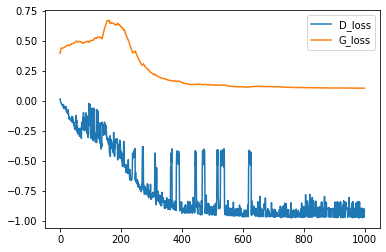

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from preprocessing import preprocess4, create_batch2
from model.model_class import Generator, Discriminator
import matplotlib.pyplot as plt

np.random.seed(12345)
torch.manual_seed(12345)

import random

random.seed(12345)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#functional_categories = ['intrinsic', 'time_based']
#functional_categories = ['intrinsic', 'time_based', 'host_based']
functional_categories = ['intrinsic', 'content']

data = pd.read_csv("dataset/GAN_train.csv")
train_data, raw_attack, normal, true_label, modification_mask \
    = preprocess4(data, functional_categories=functional_categories)

BATCH_SIZE = 256  # Batch size
GEN_ITERS = 20
CRITIC_ITERS = 1  # For WGAN and WGAN-GP, number of critic iters per gen iter
LAMBDA = 10  # Gradient penalty lambda hyperparameter
MAX_EPOCH = 1000  # How many generator iterations to train for
NOISE_SIZE = 27
generator_input_dim = train_data.shape[1] + NOISE_SIZE
generator_output_dim = train_data.shape[1]
discriminator_output_dim = 1
CLAMP = 0.01

# read parameters of IDS

modification_mask = np.tile(modification_mask, [BATCH_SIZE, 1])
modification_mask_t = torch.FloatTensor(modification_mask).to(device)

ids_model = BlackBoxWrapper(generator_output_dim, 1)
# param = torch.load('model/IDS.pth')
# ids_model.load_state_dict(param)
# read model

generator = Generator(generator_input_dim, generator_output_dim).to(device)
discriminator = Discriminator(generator_output_dim, discriminator_output_dim).to(device)


optimizer_G = optim.RMSprop(generator.parameters(), lr=0.0001)
optimizer_D = optim.RMSprop(discriminator.parameters(), lr=0.0001)

batch_attack = create_batch2(raw_attack, BATCH_SIZE)
batch_normal = create_batch2(normal, BATCH_SIZE)

d_losses, g_losses = [], []
ids_model.eval()
generator.train()
discriminator.train()
cnt = -5
print("IDSGAN start training")
print("-" * 100)

gen_attack_batch_idx = 0
dis_normal_batch_idx = 0

for epoch in range(MAX_EPOCH):

    #  Train Generator

    gen_loss = 0.
    for g in range(GEN_ITERS):

        for p in generator.parameters():
            p.requires_grad = True

        for p in discriminator.parameters():
            p.requires_grad = False

        ba = batch_attack[gen_attack_batch_idx]
        gen_attack_batch_idx = (gen_attack_batch_idx + 1) % len(batch_attack)

        optimizer_G.zero_grad()

        noise = np.random.uniform(0., 1., (BATCH_SIZE, NOISE_SIZE))
        gen_x = np.concatenate([ba, noise], axis=1)

        gen_x_t = torch.FloatTensor(gen_x).to(device)

        adversarial_attack_modification = generator(gen_x_t, modification_mask_t)
        adversarial_attack = torch.FloatTensor(ba).to(device) + adversarial_attack_modification

        D_pred = discriminator(adversarial_attack)
        g_loss = torch.mean(D_pred)
        # print("G loss")
        # print(g_loss)
        # print("\n")

        g_loss.backward()
        optimizer_G.step()

        for p in generator.parameters():
            p = torch.clamp(p, -0.01, 0.01)

        gen_loss += g_loss.item()

    gen_loss = gen_loss / GEN_ITERS

    for p in discriminator.parameters():
        p.requires_grad = True

    for p in generator.parameters():
        p.requires_grad = False

    dis_loss = 0.
    for c in range(CRITIC_ITERS):
        optimizer_D.zero_grad()

        np.random.shuffle(batch_normal)

        bn = batch_normal[dis_normal_batch_idx]
        ba = batch_attack[dis_normal_batch_idx % len(batch_attack)]
        dis_normal_batch_idx = (dis_normal_batch_idx + 1) % len(batch_normal)

        noise = np.random.uniform(0., 1., (BATCH_SIZE, NOISE_SIZE))
        gen_x = np.concatenate([ba, noise], axis=1)

        gen_x_t = torch.FloatTensor(gen_x).to(device)

        adversarial_attack_modification = generator(gen_x_t, modification_mask_t)
        adversarial_attack_t = torch.FloatTensor(ba).to(device) + adversarial_attack_modification
        adversarial_attack = adversarial_attack_t.cpu().detach().numpy()

        ids_input = np.concatenate([bn, adversarial_attack], axis=0)

        l = list(range(len(ids_input)))
        np.random.shuffle(l)

        ids_input = ids_input[l]

        ids_input = torch.FloatTensor(ids_input).to(device)

        out = ids_model(ids_input)
        out = torch.reshape(out, [len(ids_input)])
        out_np = out.cpu().detach().numpy()

        ids_pred_label = np.array(out_np > 0.5).astype(int)

        pred_normal = ids_input.cpu().detach().numpy()[ids_pred_label == 0]
        pred_attack = ids_input.cpu().detach().numpy()[ids_pred_label == 1]

        # print(len(pred_normal))
        # print(len(pred_attack))

        if len(pred_attack) == 0:
            cnt += 1
            break

        D_normal = discriminator(torch.FloatTensor(pred_normal).to(device))
        D_attack = discriminator(torch.FloatTensor(pred_attack).to(device))
        D_adv = discriminator(adversarial_attack_t)

        loss_normal = torch.mean(D_normal)
        loss_attack = torch.mean(D_attack)
        loss_adv = torch.mean(D_adv)

        # print(loss_normal)
        # print(loss_attack)
        # print(loss_adv)
        # print("\n")

        d_loss = (loss_normal - loss_attack)  # + LAMBDA * gradient_penalty
        dis_loss += d_loss.item()

        d_loss.backward()
        optimizer_D.step()

        for p in discriminator.parameters():
            p = torch.clamp(p, -0.01, 0.01)

    dis_loss = dis_loss / CRITIC_ITERS

    d_losses.append(dis_loss)
    g_losses.append(gen_loss)

    print(f"{epoch} : {gen_loss} \t {dis_loss}")

    torch.save(generator.state_dict(), 'save_model/generator.pth')
    torch.save(discriminator.state_dict(), 'save_model/discreminator.pth')

    if cnt >= 100:
        print("Not exist predicted attack traffic")
        break

print("IDSGAN finish training")
torch.save(generator.state_dict(), 'save_model/generator.pth')
torch.save(discriminator.state_dict(), 'save_model/discreminator.pth')
plt.plot(d_losses, label="D_loss")
plt.plot(g_losses, label="G_loss")
plt.legend()
plt.show()

In [ ]:
import torch
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
from preprocessing import preprocess4, create_batch2
from model.model_class import Generator
from torch import nn

np.random.seed(12345)
torch.manual_seed(12345)

import random

random.seed(12345)

test = pd.read_csv("dataset/generator_test_combined.csv")

#functional_categories = ['intrinsic', 'time_based']
#functional_categories = ['intrinsic', 'time_based', 'host_based']
functional_categories = ['intrinsic', 'content']

test, raw_attack, _, _, modification_mask = preprocess4(test, functional_categories)

raw_attack = np.array(raw_attack).astype(float)

modification_mask = np.tile(modification_mask, [len(raw_attack), 1])
modification_mask_t = torch.FloatTensor(modification_mask)

NOISE_SIZE = 27
generator_input_dim = test.shape[1] + NOISE_SIZE
generator_output_dim = test.shape[1]
discriminator_output_dim = 1

random_g = Generator(generator_input_dim, generator_output_dim)
learned_g = Generator(generator_input_dim, generator_output_dim)

# ids_model = Blackbox_IDS(generator_output_dim, 1)
# param = torch.load('model/IDS.pth')
# ids_model.load_state_dict(param)
ids_model = BlackBoxWrapper(generator_output_dim, 1)

g_param = torch.load('save_model/generator.pth')
learned_g.load_state_dict(g_param)

# original detection rate

x_t = torch.FloatTensor(raw_attack).to(device)

out = ids_model(x_t)
out = torch.reshape(out, [len(raw_attack)])
out_np = out.cpu().detach().numpy()

ids_pred_label = np.array(out_np > 0.5).astype(int)
corr = np.sum(ids_pred_label)

original_det_rate = corr / len(raw_attack)

print("original detection rate : {}".format(original_det_rate))

# adv. detection rate : random generator

noise = np.random.uniform(0., 1., (len(raw_attack), NOISE_SIZE))
gen_x = np.concatenate([raw_attack, noise], axis=1)

gen_x_t = torch.FloatTensor(gen_x)

adversarial_attack_modification = random_g(gen_x_t, modification_mask_t)
adversarial_attack = torch.FloatTensor(raw_attack) + adversarial_attack_modification

out = ids_model(adversarial_attack)
out = torch.reshape(out, [len(adversarial_attack)])
out_np = out.cpu().detach().numpy()

# print(adversarial_attack_modification[0])
# print(adversarial_attack_modification[1])

ids_pred_label = np.array(out_np > 0.5).astype(int)
corr = np.sum(ids_pred_label)

adv_det_rate_rand = corr / len(raw_attack)

print("adversarial detection rate (random): {}".format(adv_det_rate_rand))

# adv. detection rate : learned generator

adversarial_attack_modification_l = learned_g(gen_x_t, modification_mask_t)
adversarial_attack_l = torch.FloatTensor(raw_attack) + adversarial_attack_modification_l

#print(adversarial_attack_modification_l[0])
# print(adversarial_attack_modification[1])

out = ids_model(adversarial_attack_l)
out = torch.reshape(out, [len(adversarial_attack_l)])
out_np = out.cpu().detach().numpy()

print(np.min(adversarial_attack_modification_l.cpu().detach().numpy(), axis=0))
print(np.max(adversarial_attack_modification_l.cpu().detach().numpy(), axis=0))


# print(np.sum(np.abs(adversarial_attack_l.detach().numpy() - raw_attack) < 0.001)/len(raw_attack))
ids_pred_label = np.array(out_np > 0.5).astype(int)
corr = np.sum(ids_pred_label)

adv_det_rate_learned = corr / len(raw_attack)

print("adversarial detection rate (learned): {}".format(adv_det_rate_learned))


original detection rate : 0.03656059580230196
adversarial detection rate (random): 0.037237643872714964
[ 0.          0.         -0.         -0.         -0.         -0.
  0.         -0.         -0.         -0.         -0.          0.
 -0.         -0.          0.         -0.         -0.         -0.
  0.          0.         -0.         -0.          0.          0.
  0.         -0.          0.          0.         -0.         -0.
 -0.         -0.         -0.          0.          0.          0.
  0.          0.         -0.          0.         -0.         -0.
  0.         -0.          0.         -0.         -0.         -0.
 -0.         -0.          0.          0.         -0.         -0.
 -0.         -0.          0.         -0.          0.          0.
  0.         -0.         -0.          0.         -0.          0.
 -0.         -0.         -0.         -0.          0.         -0.
 -0.         -0.          0.          0.          0.          0.
 -0.          0.         -0.         -0.         -0

#Fuzzyness IDS
## 100% Labeled
original detection rate : 0.8531777956556718  
adversarial detection rate (random): 0.8323947438991687  
adversarial detection rate (learned): 0.6423974255832663  

## 90% Label
original detection rate : 0.8393671225529633  
adversarial detection rate (random): 0.8356127648163046  
adversarial detection rate (learned): 0.6158487530168946  

## 50% Label
original detection rate : 0.8454009117725931  
adversarial detection rate (random): 0.8472780906409225    
adversarial detection rate (learned): 0.5922499329578975

## 10% Label
original detection rate : 0.8581389112362564  
adversarial detection rate (random): 0.8565299007776884    
adversarial detection rate (learned): 0.6773934030571199  




#Vanilla NN as BlackBoxIDS
original detection rate : 0.8175113971574148   
adversarial detection rate (random): 0.8205953338696702   
adversarial detection rate (learned): 0.27715205148833466

#RNN as BlackBoxIDS
## 100% Data
original detection rate : 0.8765084473049075  
adversarial detection rate (random): 0.8679270581925449  
adversarial detection rate (learned): 0.6790024135156878    

## 90% Data
original detection rate : 0.8207294180745508  
adversarial detection rate (random): 0.8172432287476535    
adversarial detection rate (learned): 0.6533923303834809  

## 50% Data
original detection rate : 0.8576025744167337  
adversarial detection rate (random): 0.857870742826495    
adversarial detection rate (learned): 0.6310002681684097    

## 10% Data
original detection rate : 0.8527755430410298  
adversarial detection rate (random): 0.8487530168946098    
adversarial detection rate (learned): 0.6924108340037544    



#Our IDS

##Trained with 100% Labelled Data
original detection rate : 0.8425851434700993  
adversarial detection rate (random): 0.8411102172164119  
adversarial detection rate (learned): 0.7139983909895414

##Trained with 90% Labelled Data
original detection rate : 0.8228747653526415  
adversarial detection rate (random): 0.8169750603378922  
adversarial detection rate (learned): 0.7294180745508179

##Trained with 50% Labelled Data
original detection rate : 0.8472780906409225  
adversarial detection rate (random): 0.8472780906409225  
adversarial detection rate (learned): 0.7687047465808527  

##Trained with 10% Labelled Data
original detection rate : 0.8336015017430947  
adversarial detection rate (random): 0.8148297130598016  
adversarial detection rate (learned): 0.7959238401716278